<a href="https://colab.research.google.com/github/patrickmurphym/Egg_Prices_Forecast/blob/main/TS_Project_(Linear_and_MA_forecast).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Price Forecasting of Egg Prices: A Time Series Analysis

- A project aimed to analyze the time series of egg prices by first detrending the data to remove any long-term trends, then deseasonalizing it to remove any seasonal cycles, and finally fitting an ARMA model to capture any remaining autocorrelation and moving average patterns in the data.
- By doing so, we sought to gain insights into the cyclical patterns of egg prices and to develop a model that could be used to forecast future prices. The results of the analysis could be useful for stakeholders in the egg industry, such as producers, distributors, and consumers, in making informed decisions about pricing and supply chain management.

Teammates (alphabetical order):

*   Biswas, Debapriya
*   Murphy, Patrick
*   Pathak, Riddhi



In [ ]:
#Import the necessary Python packages

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

In [ ]:
#Load the data from the Excel file

data = pd.read_excel('Data.xls', usecols = ['TIME', 'Value'])
# data['TIME'] = pd.to_datetime(data['TIME'], format = '%Y-%m')
data

,TIME,Value
0,2000-01-01,0.975
1,2000-02-01,0.962
2,2000-03-01,0.931
3,2000-04-01,0.939
4,2000-05-01,0.852
...,...,...
274,2022-11-01,3.589
275,2022-12-01,4.250
276,2023-01-01,4.823
277,2023-02-01,4.211


# Exploratory Data Analysis

Text(0, 0.5, 'Egg Prices')

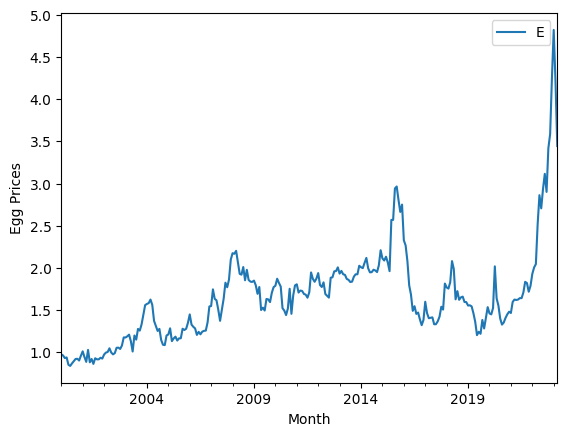

In [ ]:
data.plot(x='TIME',
         y='Value')
ax = plt.gca()
ax.legend('Egg Prices')
ax.set_xlabel('Month')
ax.set_ylabel('Egg Prices')

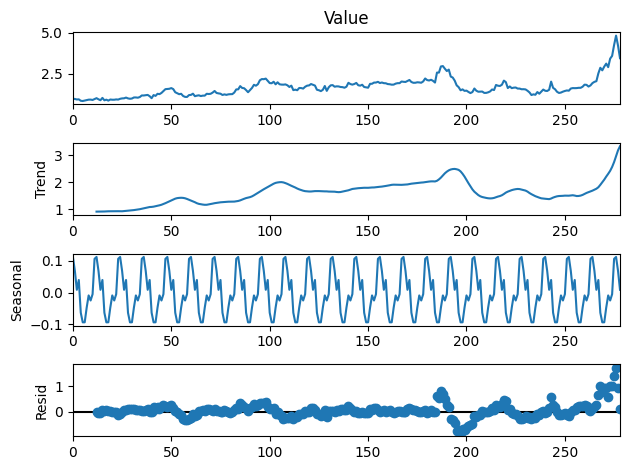

In [ ]:
result = seasonal_decompose(data["Value"], period=12, two_sided = False)
fig = result.plot()
plt.show()

In [ ]:
data['Month'] = data.index
data.head()

,TIME,Value,Month
0,2000-01-01,0.975,0
1,2000-02-01,0.962,1
2,2000-03-01,0.931,2
3,2000-04-01,0.939,3
4,2000-05-01,0.852,4


In [ ]:
# Function to check stationarity

def adf_test(data_set):
    print("Observations from Dickey-fuller test")
    dftest = adfuller(data_set.dropna())
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]= value
    print(dfoutput)

    result = adfuller(data_set)

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.")
    else:
        print("Weak evidence against null hypothesis. Time series is non-stationary.")

In [ ]:
#Split Data into Test and Train

total_size = data.shape[0]
train_size = int(total_size*0.8)

data_train = data.iloc[:train_size]
data_test  = data.iloc[train_size:]

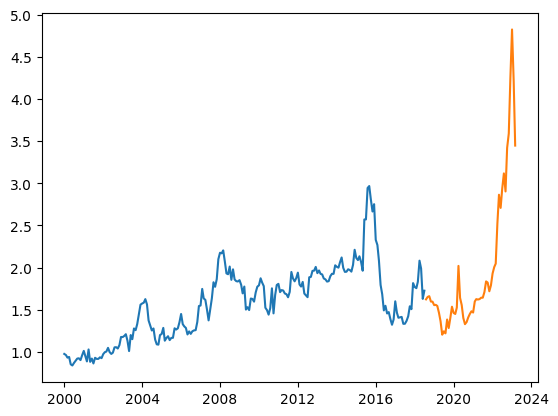

In [ ]:
 #Plot Test and Train Data

plt.plot(data_train['TIME'], data_train['Value'])
plt.plot(data_test['TIME'], data_test['Value'])
plt.show()

# Removing Trend and Seasonality

Detrending Method 1: Linear Trend

In [ ]:
lr = LinearRegression(fit_intercept = True)
lr.fit(data_train[['Month']],data_train['Value'])

LinearRegression()

In [ ]:
print("slope: {}".format(lr.coef_[0]))
print("intercept: {}".format(lr.intercept_))

slope: 0.004840397051439652
intercept: 1.0334827434336962


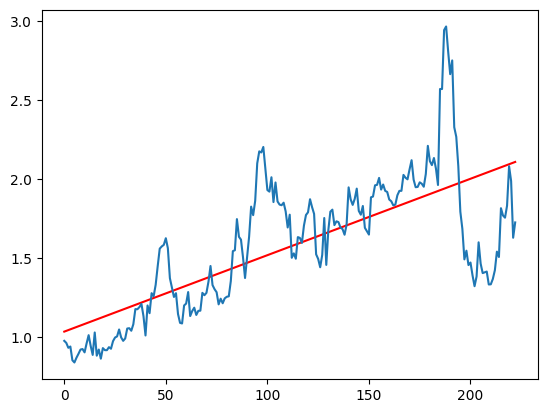

In [ ]:
plt.plot(data_train[['Month']], lr.predict(data_train[['Month']]), color = "red")
plt.plot(data_train['Value'])

In [ ]:
data_train['Detrend'] = data_train['Value'] - data_train['Month'] * lr.coef_[0] - lr.intercept_

<ipython-input-324-bc14030a5318>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Detrend'] = data_train['Value'] - data_train['Month'] * lr.coef_[0] - lr.intercept_


In [ ]:
data_train.head()

,TIME,Value,Month,Detrend
0,2000-01-01,0.975,0,-0.058483
1,2000-02-01,0.962,1,-0.076323
2,2000-03-01,0.931,2,-0.112164
3,2000-04-01,0.939,3,-0.109004
4,2000-05-01,0.852,4,-0.200844


Removing Seasonality

In [ ]:
def seasonal_mean(data, freq=12):
  data = data.dropna()
  averages = np.zeros(shape=freq)
  count = np.zeros(shape=freq)
  for i in range(len(data)):
    averages[i % freq] += data.iloc[i]
    count[i % freq] += 1
  averages = (averages / count)
  seasonal = [ averages[i % freq] for i in range(len(data)) ]
  return averages

In [ ]:
seasonality_1 = seasonal_mean(data_train['Detrend'])

In [ ]:
sum(seasonality_1)

0.0043420659271525

In [ ]:
seasonal_train_1 = [ seasonality_1[i%12] for i in range(len(data_train)) ]
data_train['residual'] = data_train['Detrend'] - pd.Series(seasonal_train_1, index=data_train.index)

<ipython-input-329-20cdda818a1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['residual'] = data_train['Detrend'] - pd.Series(seasonal_train_1, index=data_train.index)


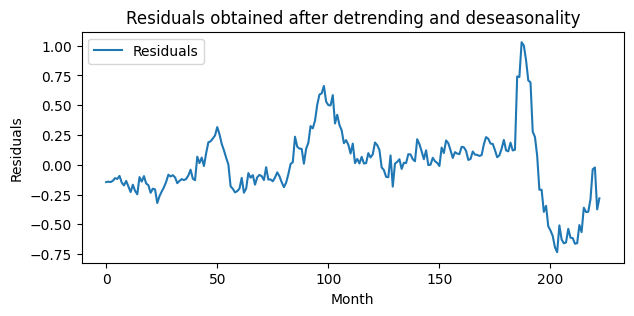

In [ ]:
plt.figure(figsize=(7, 3))
# create a line plot with title, x-axis label, and y-axis label
plt.plot(data_train['Month'], data_train['residual'],label='Residuals')
plt.title('Residuals obtained after detrending and deseasonality')
plt.xlabel('Month')
plt.ylabel('Residuals')
# show the legend
plt.legend()
plt.show()

In [ ]:
adf_test(data_train['residual'])

Observations from Dickey-fuller test
Test Statistic                  -3.422920
p-value                          0.010202
#lags used                       4.000000
number of observations used    218.000000
critical value (1%)             -3.460708
critical value (5%)             -2.874891
critical value (10%)            -2.573886
dtype: float64
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


#### Based on the outcome of the ADF test, it is evident that the residual series is stationary, which allows us to utilize an ARMA model for it.

### Detrending Method 2: Moving Average

In [ ]:
def detrend(ts, w):
    detrended = [np.nan]*(w-1)
    for i in range(w, len(ts)+1):
        trend = sum(ts[i-w:i])/w
        detrended.append(ts[i-1] - trend)
    return detrended

In [ ]:
train_set_detrend_ma = data_train.iloc[0: , :]
train_set_detrend_ma

,TIME,Value,Month,Detrend,residual
0,2000-01-01,0.975,0,-0.058483,-0.145658
1,2000-02-01,0.962,1,-0.076323,-0.142027
2,2000-03-01,0.931,2,-0.112164,-0.145237
3,2000-04-01,0.939,3,-0.109004,-0.134711
4,2000-05-01,0.852,4,-0.200844,-0.112395
...,...,...,...,...,...
218,2018-03-01,1.831,218,-0.257689,-0.290763
219,2018-04-01,2.081,219,-0.012530,-0.038237
220,2018-05-01,1.987,220,-0.111370,-0.022921
221,2018-06-01,1.628,221,-0.475210,-0.374816


In [ ]:
train_set_detrend_ma['Detrending using One-Sided Moving Average'] = detrend(data_train['Value'], 4)
train_set_detrend_ma = train_set_detrend_ma.dropna()
train_set_detrend_ma

<ipython-input-334-ea72d807b17d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_detrend_ma['Detrending using One-Sided Moving Average'] = detrend(data_train['Value'], 4)


,TIME,Value,Month,Detrend,residual,Detrending using One-Sided Moving Average
3,2000-04-01,0.939,3,-0.109004,-0.134711,-0.01275
4,2000-05-01,0.852,4,-0.200844,-0.112395,-0.06900
5,2000-06-01,0.838,5,-0.219685,-0.119290,-0.05200
6,2000-07-01,0.868,6,-0.194525,-0.093553,-0.00625
7,2000-08-01,0.893,7,-0.174366,-0.149668,0.03025
...,...,...,...,...,...,...
218,2018-03-01,1.831,218,-0.257689,-0.290763,0.03850
219,2018-04-01,2.081,219,-0.012530,-0.038237,0.22200
220,2018-05-01,1.987,220,-0.111370,-0.022921,0.07350
221,2018-06-01,1.628,221,-0.475210,-0.374816,-0.25375


### Removing Seasonality

In [ ]:
seasonality_2 = seasonal_mean(train_set_detrend_ma['Detrending using One-Sided Moving Average'])

In [ ]:
seasonal_train_2 = [ seasonality_2[i % 12] for i in range(len(train_set_detrend_ma)) ]
train_set_detrend_ma['Residual using One-Sided Moving Average'] = train_set_detrend_ma['Detrending using One-Sided Moving Average'] - pd.Series(seasonal_train_2, index=train_set_detrend_ma.index)

<ipython-input-336-aef8b9b85541>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_detrend_ma['Residual using One-Sided Moving Average'] = train_set_detrend_ma['Detrending using One-Sided Moving Average'] - pd.Series(seasonal_train_2, index=train_set_detrend_ma.index)


In [ ]:
train_set_detrend_ma['Trend using One-Sided Moving Average'] = train_set_detrend_ma['Value'] - train_set_detrend_ma['Detrending using One-Sided Moving Average']
train_set_detrend_ma

<ipython-input-337-97555defbc95>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_detrend_ma['Trend using One-Sided Moving Average'] = train_set_detrend_ma['Value'] - train_set_detrend_ma['Detrending using One-Sided Moving Average']


,TIME,Value,Month,Detrend,residual,Detrending using One-Sided Moving Average,Residual using One-Sided Moving Average,Trend using One-Sided Moving Average
3,2000-04-01,0.939,3,-0.109004,-0.134711,-0.01275,0.007197,0.95175
4,2000-05-01,0.852,4,-0.200844,-0.112395,-0.06900,0.021197,0.92100
5,2000-06-01,0.838,5,-0.219685,-0.119290,-0.05200,0.008618,0.89000
6,2000-07-01,0.868,6,-0.194525,-0.093553,-0.00625,0.021434,0.87425
7,2000-08-01,0.893,7,-0.174366,-0.149668,0.03025,-0.021500,0.86275
...,...,...,...,...,...,...,...,...
218,2018-03-01,1.831,218,-0.257689,-0.290763,0.03850,0.067972,1.79250
219,2018-04-01,2.081,219,-0.012530,-0.038237,0.22200,0.241947,1.85900
220,2018-05-01,1.987,220,-0.111370,-0.022921,0.07350,0.163697,1.91350
221,2018-06-01,1.628,221,-0.475210,-0.374816,-0.25375,-0.193132,1.88175


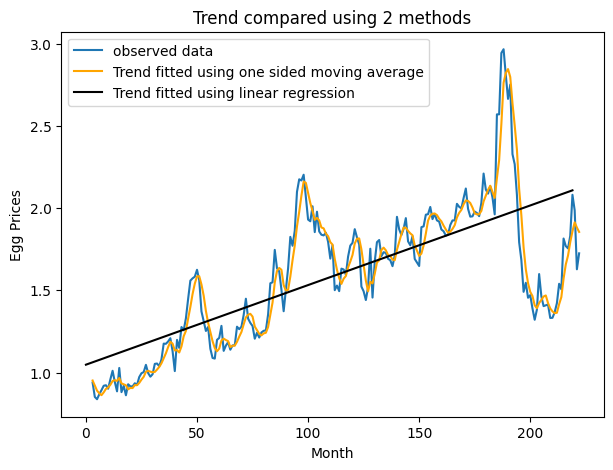

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(train_set_detrend_ma['Value'],label='observed data')
plt.plot(train_set_detrend_ma[['Month']], train_set_detrend_ma[['Trend using One-Sided Moving Average']], label='Trend fitted using one sided moving average', color = "orange")
plt.plot(lr.predict(train_set_detrend_ma[['Month']]),label='Trend fitted using linear regression', color = "black")
plt.xlabel('Month')
plt.ylabel('Egg Prices')
plt.title('Trend compared using 2 methods')
plt.legend()

In [ ]:
train_set_detrend_ma['Trend plus seasonality'] = train_set_detrend_ma['Trend using One-Sided Moving Average'] + pd.Series(seasonal_train_2, index = train_set_detrend_ma.index)
train_set_detrend_ma['Trend plus seasonality']

<ipython-input-339-7b65092701d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_detrend_ma['Trend plus seasonality'] = train_set_detrend_ma['Trend using One-Sided Moving Average'] + pd.Series(seasonal_train_2, index = train_set_detrend_ma.index)


3      0.931803
4      0.830803
5      0.829382
6      0.846566
7      0.914500
         ...   
218    1.763028
219    1.839053
220    1.823303
221    1.821132
222    1.827566
Name: Trend plus seasonality, Length: 220, dtype: float64

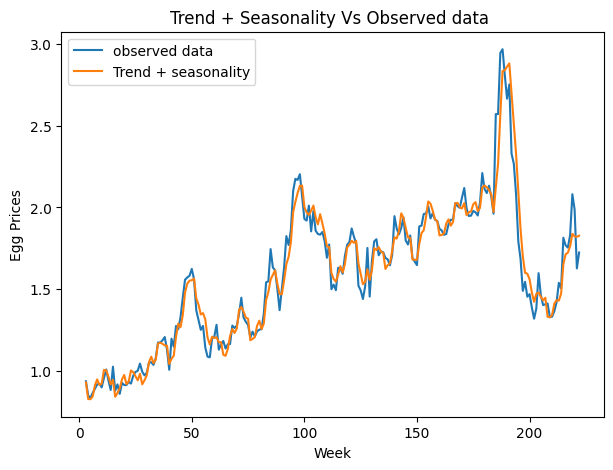

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(train_set_detrend_ma['Value'], label='observed data')
plt.plot(train_set_detrend_ma[['Month']], train_set_detrend_ma['Trend plus seasonality'], label='Trend + seasonality')
plt.xlabel('Week')
plt.ylabel('Egg Prices')
plt.title('Trend + Seasonality Vs Observed data ')
plt.legend()

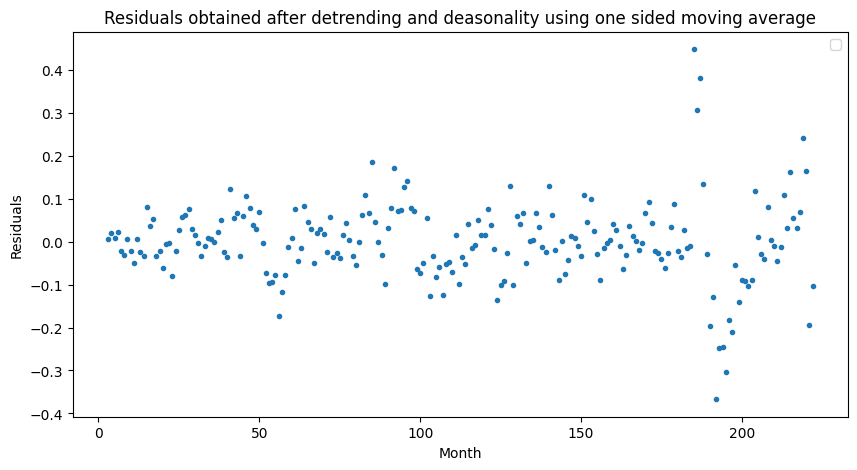

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_set_detrend_ma['Month'], train_set_detrend_ma['Residual using One-Sided Moving Average'], '.')
plt.title('Residuals obtained after detrending and deasonality using one sided moving average')
plt.xlabel('Month')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [ ]:
adf_test(train_set_detrend_ma['Residual using One-Sided Moving Average'].dropna())

Observations from Dickey-fuller test
Test Statistic                -6.263867e+00
p-value                        4.159676e-08
#lags used                     2.000000e+00
number of observations used    2.170000e+02
critical value (1%)           -3.460849e+00
critical value (5%)           -2.874953e+00
critical value (10%)          -2.573919e+00
dtype: float64
Strong evidence against the null hypothesis. Reject the null hypothesis. Data is stationary.


# Fitting ARMA Model

### Linear Regression trend

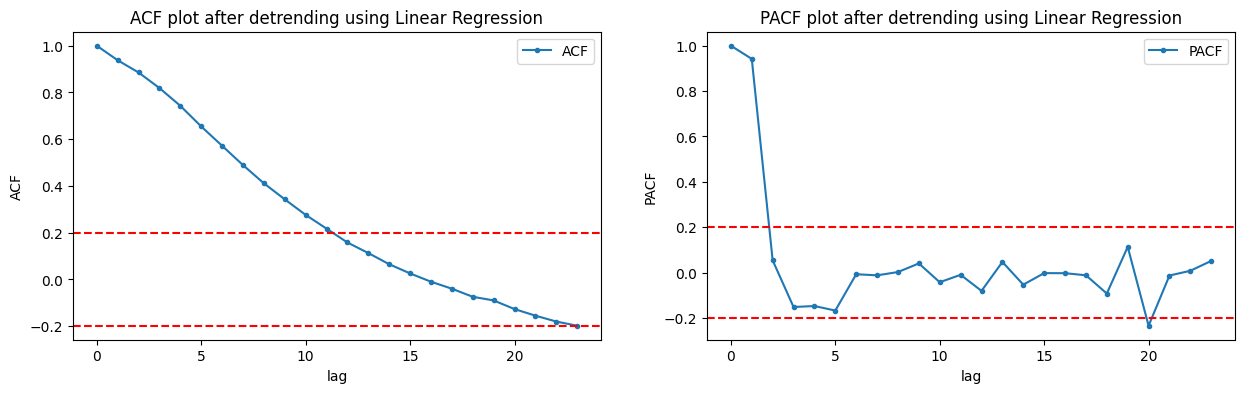

In [ ]:
threshold = 0.2
ACF = acf(data_train['residual'])
PACF = pacf(data_train['residual'])

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(ACF,'.-',label='ACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF plot after detrending using Linear Regression')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(PACF,'.-',label='PACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.title('PACF plot after detrending using Linear Regression')
plt.legend()

- Now that we have our ACF and PACF graphs we can deduce the orders of the AR and MA for the model according to the values for the various lags.<br>
- Used to decide the AR order: PACF <br>
We see that the first lag exceed the 2 dotted horizontal lines. <br>
- Used to decide the MA order: ACF<br>
Only the first 11 lags have a value exceeding the 2 dotted horizontal lines. <br>

Therefore, the ARMA order will be (1, 11)<br>

In [ ]:
arima_model_1_11 = ARIMA(data_train['residual'], order=(1,0,11))
model_1_11 = arima_model_1_11.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### For the purposes of understanding the working better first let us simply predict the in sample data. i.e. without adding the seasonality and the residuals

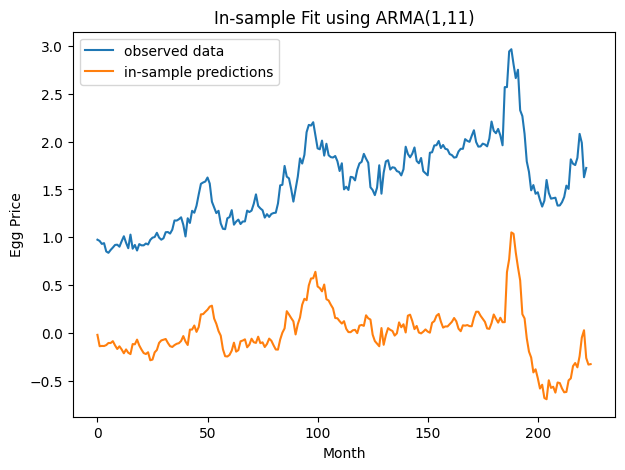

In [ ]:
predictions = model_1_11.predict(start = 0, end = len(data_train)+1)
plt.figure(figsize=(7,5))
plt.plot(data_train['Value'], label='observed data')
plt.plot(predictions, label='in-sample predictions')
plt.xlabel('Month')
plt.ylabel('Egg Price')
plt.title('In-sample Fit using ARMA(1,11)')
plt.legend()

Thus, we see that the predictions imitate the observed data but there is constant difference between the 2 data. <br>
#### Thus, next we add the seasonality and trend

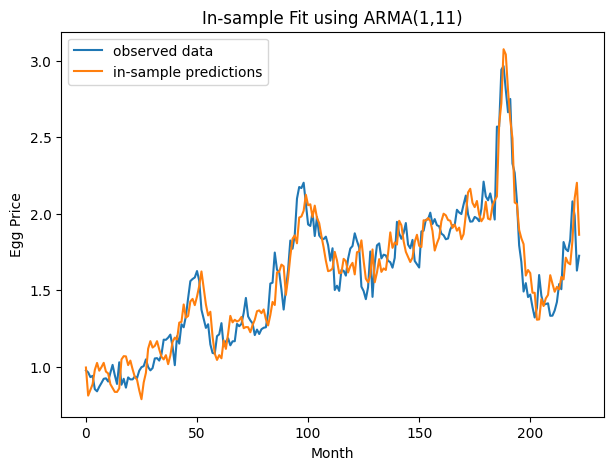

In [ ]:
predictions = model_1_11.predict(start = 0, end = len(data_train)+1) + pd.Series([seasonality[t % 12] for t in data_train['Month']], index = data_train.index) + data_train['Month'] * lr.coef_[0] + lr.intercept_
plt.figure(figsize=(7,5))
plt.plot(data_train['Value'], label='observed data')
plt.plot(predictions, label='in-sample predictions')
plt.xlabel('Month')
plt.ylabel('Egg Price')
plt.title('In-sample Fit using ARMA(1,11)')
plt.legend()

### MA trend

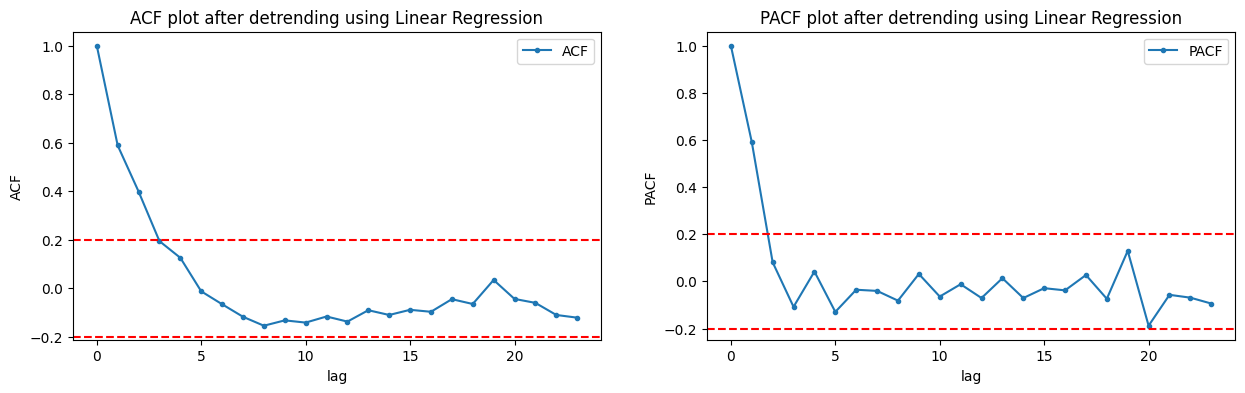

In [ ]:
threshold = 0.2
ACF = acf(train_set_detrend_ma['Residual using One-Sided Moving Average'].dropna())
PACF = pacf(train_set_detrend_ma['Residual using One-Sided Moving Average'].dropna())

plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(ACF,'.-',label='ACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF plot after detrending using Linear Regression')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(PACF,'.-',label='PACF')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.xlabel('lag')
plt.ylabel('PACF')
plt.title('PACF plot after detrending using Linear Regression')
plt.legend()

In [ ]:
arima_model_1_2 = ARIMA(train_set_detrend_ma['Residual using One-Sided Moving Average'].dropna(), order=(1,0,2))
model_1_2 = arima_model_1_2.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


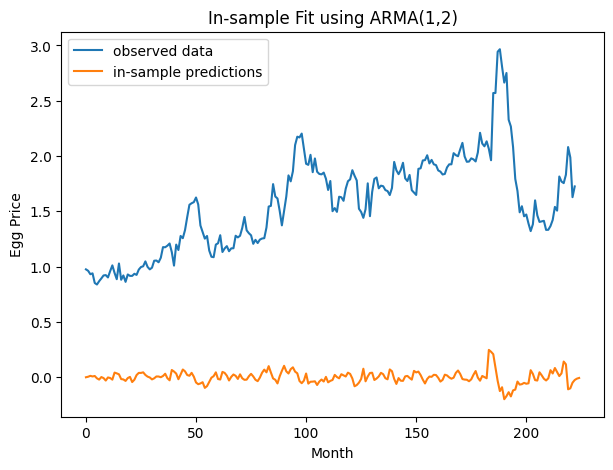

In [ ]:
predictions = model_1_2.predict(start = 0, end = len(data_train)+1)
plt.figure(figsize=(7,5))
plt.plot(data_train['Value'], label='observed data')
plt.plot(predictions, label='in-sample predictions')
plt.xlabel('Month')
plt.ylabel('Egg Price')
plt.title('In-sample Fit using ARMA(1,2)')
plt.legend()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


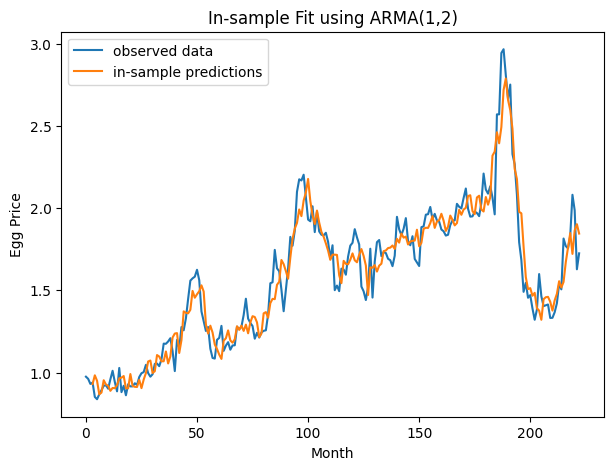

In [ ]:
predictions  = pd.Series(model_1_2.predict(start = 0, end = len(data_train)), index = data_train.index)
predictions += pd.Series([np.nan]*3+[sum(data_train['Value'][i-4:i])/4 for i in range(4, int(len(data_train))+1)], index = data_train.index)
predictions += pd.Series([seasonality_2[t % 12] for t in data_train['Month']], index = data_train.index)

plt.figure(figsize=(7,5))
plt.plot(data_train['Value'], label='observed data')
plt.plot(predictions, label='in-sample predictions')
plt.xlabel('Month')
plt.ylabel('Egg Price')
plt.title('In-sample Fit using ARMA(1,2)')
plt.legend()

# Forecasting the Data

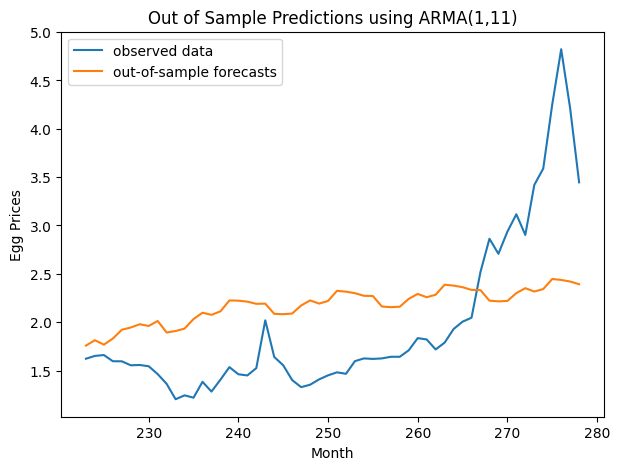

In [ ]:
forecasts_1_11 = model_1_11.forecast(steps = len(data_test)) + pd.Series([seasonality_1[t % 12] for t in data_test['Month']], index = data_test.index) + data_test['Month'] * lr.coef_[0] + lr.intercept_
plt.figure(figsize=(7, 5))
plt.plot(data_test['Value'], label='observed data')
plt.plot(forecasts_1_11, label='out-of-sample forecasts')
plt.xlabel('Month')
plt.ylabel('Egg Prices')
plt.title('Out of Sample Predictions using ARMA(1,11)')
plt.legend()

- We see that the model is not doing the best job at predicting the values, this is because if we go back to look at the data. (Separation of the train and test data)
>We see that, the test data was actually not cohesive with trend that the data followed until the sliced segment.
- Therefore, we see in the out of sample prediction that the prediction is not as well as it could have been. This discrepancy can also be attributed to the fact that we do not have a lot of variation in our input data.

In [ ]:
def forecast_trend(initial_values, f_noise_and_seasonality):
  trend = list(initial_values)
  for i in range(len(f_noise_and_seasonality)):
    trend.append(sum(trend[i:i+4])/4)
  return trend[4:]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


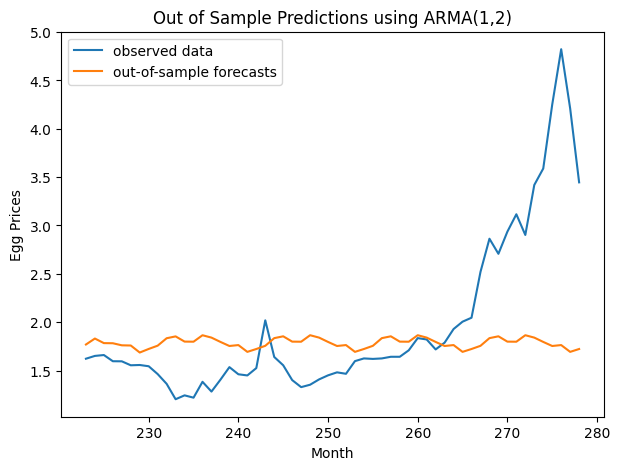

In [ ]:
forecasts_1_2 = model_1_2.forecast(steps = len(data_test))
forecasts_1_2.index = data_test.index
forecasts_1_2 += pd.Series([seasonality_2[t % 12] for t in data_test['Month']], index = data_test.index)
forecasts_1_2 += pd.Series(forecast_trend(data_train['Value'][len(data_train)-4:len(data_train)], forecasts_1_2), index = data_test.index)

plt.figure(figsize=(7, 5))
plt.plot(data_test['Value'], label='observed data')
plt.plot(forecasts_1_2, label='out-of-sample forecasts')
plt.xlabel('Month')
plt.ylabel('Egg Prices')
plt.title('Out of Sample Predictions using ARMA(1,2)')
plt.legend()